In [50]:
!pip install torchvision
!pip install torch
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import random

class PomeranianActivityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = ["Eat", "Play", "Sleep"]
        self.transform = transform
        self.samples = []

        for class_name in self.classes:
            class_folder = os.path.join(root_dir, f"{class_name}Frames")
            for video_dir in os.listdir(class_folder):
                frame_folder = os.path.join(class_folder, video_dir)
                if os.path.isdir(frame_folder):
                    frame_files = sorted(os.listdir(frame_folder))
                    self.samples.append((frame_folder, class_name, frame_files))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_folder, class_name, frame_files = self.samples[idx]
        # Randomly select one frame for now
        frame_path = os.path.join(frame_folder, random.choice(frame_files))
        image = Image.open(frame_path).convert("RGB")
        label = self.classes.index(class_name)

        if self.transform:
            image = self.transform(image)

        return image, label
    



        


In [52]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [53]:
train_dataset = PomeranianActivityDataset(
    root_dir=r"D:\DOG project",
    transform=train_transforms
)


In [54]:
from collections import Counter

# Get list of all labels from the dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

# Count occurrences of each label
label_counts = Counter(all_labels)

# Map label indices back to class names for readability
for label_idx, count in label_counts.items():
    class_name = train_dataset.classes[label_idx]
    print(f"{class_name}: {count} samples")


Eat: 192 samples
Play: 166 samples
Sleep: 318 samples


In [55]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, WeightedRandomSampler
import torch

# Step 1: Get video-level samples and labels
all_samples = train_dataset.samples
all_labels = []
for frame_folder, class_name, frame_files in all_samples:
    label = train_dataset.classes.index(class_name)
    all_labels.append(label)

# Step 2: Split by video folder (NOT frame)
train_indices, val_indices = train_test_split(
    list(range(len(all_samples))),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

# Step 3: Create Subsets using these indices
train_subset = Subset(train_dataset, train_indices)
val_dataset = PomeranianActivityDataset(
    root_dir=r"D:\DOG project",
    transform=val_transforms
)
val_subset = Subset(val_dataset, val_indices)
print("Validation samples:", len(val_subset))
val_labels = [val_dataset[i][1] for i in val_indices]
from collections import Counter
print("Validation set class distribution:", Counter(val_labels))

# Step 4: Compute class weights for train_sampler
label_counts = [0] * len(train_dataset.classes)
for idx in train_indices:
    label = train_dataset[idx][1]
    label_counts[label] += 1

class_weights = [1.0 / count for count in label_counts]
train_sample_weights = [class_weights[sample[1]] for sample in train_subset]

train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_subset), replacement=True)

# Step 5: Final DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


Validation samples: 136
Validation set class distribution: Counter({2: 64, 0: 39, 1: 33})


In [56]:
train_folders = set(train_dataset.samples[i][0] for i in train_indices)
val_folders = set(train_dataset.samples[i][0] for i in val_indices)
print("Overlap:", train_folders & val_folders)  # should print: Overlap: set()


Overlap: set()


In [57]:
from collections import Counter

sampled_indices = list(train_sampler)
sampled_labels = [train_subset[i][1] for i in sampled_indices]

print(Counter(sampled_labels))


Counter({0: 198, 2: 181, 1: 161})


In [37]:
#Baseline model

In [ ]:
import numpy as np
import cv2

def motion_baseline(clip_path):
    cap = cv2.VideoCapture(clip_path)
    ret, prev = cap.read()
    if not ret:
        return "Sleep"  # default if error

    total_diff = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        diff = np.mean(np.abs(frame.astype(np.float32) - prev.astype(np.float32)))
        total_diff += diff
        prev = frame

    cap.release()
    return "Play" if total_diff > 5000000 else "Sleep"  # tune this threshold


In [20]:
import os
import cv2
import numpy as np

# === CONFIG ===
base_dir = r"D:\DOG project"
activity_dirs = ["Eat", "Play", "Sleep"]  # Ground-truth folders
threshold = 5_000_000  # Tune if needed

def motion_baseline(clip_path):
    cap = cv2.VideoCapture(clip_path)
    ret, prev = cap.read()
    if not ret:
        return "Sleep"  # default if read fails

    total_diff = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        diff = np.mean(np.abs(frame.astype(np.float32) - prev.astype(np.float32)))
        total_diff += diff
        prev = frame

    cap.release()
    return "Play" if total_diff > threshold else "Sleep"

# === RUN BASELINE ON ALL CLIPS ===
correct = 0
total = 0

for true_label in activity_dirs:
    folder_path = os.path.join(base_dir, true_label)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            clip_path = os.path.join(folder_path, file)
            pred = motion_baseline(clip_path)
            total += 1
            if pred == true_label:
                correct += 1
            print(f"{file}: predicted={pred} | true={true_label}")

# === PRINT ACCURACY ===
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Motion baseline accuracy: {accuracy:.2%} ({correct}/{total})")


Next1_clip_012.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_084.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_085.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_086.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_087.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_088.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_089.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_090.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_091.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_092.mp4: predicted=Sleep | true=Eat
PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_2

In [ ]:
#ResNet18

In [58]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: Eat, Play, Sleep

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to("cuda" if torch.cuda.is_available() else "cpu")
        labels = labels.to("cuda" if torch.cuda.is_available() else "cpu")

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"✅ Train Loss: {total_loss:.4f}, Accuracy: {accuracy:.2%}")


In [60]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    misclassified = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to("cuda" if torch.cuda.is_available() else "cpu")
            labels = labels.to("cuda" if torch.cuda.is_available() else "cpu")

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store results
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Store misclassified indices
            for j in range(len(preds)):
                if preds[j] != labels[j]:
                    misclassified.append((i * dataloader.batch_size + j, preds[j].item(), labels[j].item()))

    accuracy = correct / total
    print(f" Val Loss :) {total_loss:.4f}, Accuracy: {accuracy:.2%}")

    return y_true, y_pred, misclassified


🌀 Epoch 1/10
✅ Train Loss: 7.5321, Accuracy: 83.15%
 Val Loss :) 0.5386, Accuracy: 95.59%

🌀 Epoch 2/10
✅ Train Loss: 1.6417, Accuracy: 96.67%
 Val Loss :) 0.5907, Accuracy: 95.59%

🌀 Epoch 3/10
✅ Train Loss: 1.3816, Accuracy: 97.59%
 Val Loss :) 0.3153, Accuracy: 98.53%

🌀 Epoch 4/10
✅ Train Loss: 1.0068, Accuracy: 98.33%
 Val Loss :) 0.2973, Accuracy: 97.79%

🌀 Epoch 5/10
✅ Train Loss: 1.1723, Accuracy: 97.59%
 Val Loss :) 0.2490, Accuracy: 99.26%

🌀 Epoch 6/10
✅ Train Loss: 1.0052, Accuracy: 98.33%
 Val Loss :) 0.3270, Accuracy: 97.79%

🌀 Epoch 7/10
✅ Train Loss: 0.4699, Accuracy: 98.70%
 Val Loss :) 0.3977, Accuracy: 97.79%

🌀 Epoch 8/10
✅ Train Loss: 0.5186, Accuracy: 99.07%
 Val Loss :) 0.2577, Accuracy: 97.79%

🌀 Epoch 9/10
✅ Train Loss: 0.3564, Accuracy: 99.26%
 Val Loss :) 0.2954, Accuracy: 98.53%

🌀 Epoch 10/10
✅ Train Loss: 0.3332, Accuracy: 99.26%
 Val Loss :) 0.2516, Accuracy: 97.79%
✅ Model saved successfully.
 Val Loss :) 0.1997, Accuracy: 98.53%
              precision

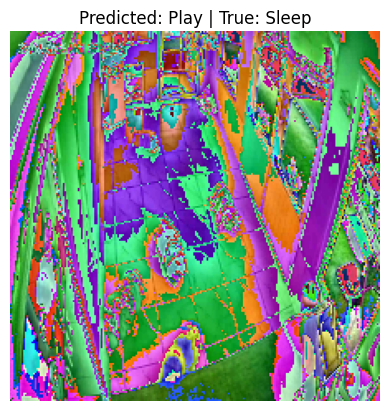

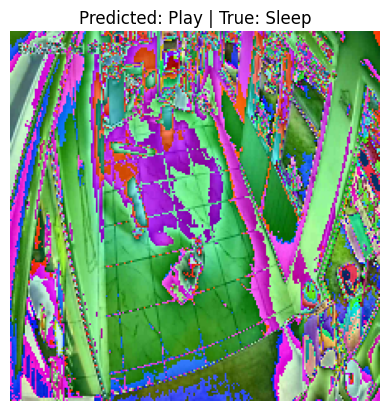

In [61]:
import matplotlib.pyplot as plt
epochs = 10
for epoch in range(epochs):
    print(f"\n🌀 Epoch {epoch+1}/{epochs}")
    train_one_epoch(model, train_loader, criterion, optimizer)
    evaluate(model, val_loader, criterion)
# AFTER TRAINING: Final evaluation + misclassified sample visualization
torch.save(model.state_dict(), "D:/DOG project/model.pth")
print("✅ Model saved successfully.")

y_true, y_pred, misclassified = evaluate(model, val_loader, criterion)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\n❌ Showing up to 5 misclassified validation images:\n")

for idx, pred_label, true_label in misclassified[:5]:
    image_tensor, _ = val_subset[idx]
    image_display = transforms.ToPILImage()(image_tensor.cpu())

    plt.imshow(image_display)
    plt.axis('off')
    plt.title(f"Predicted: {train_dataset.classes[pred_label]} | True: {train_dataset.classes[true_label]}")
    plt.show()


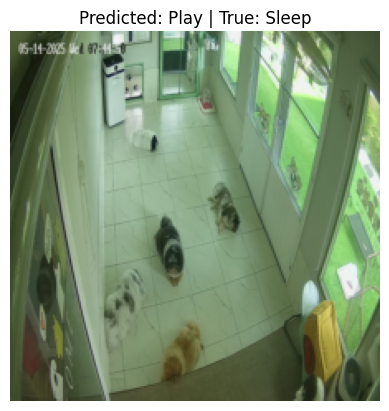

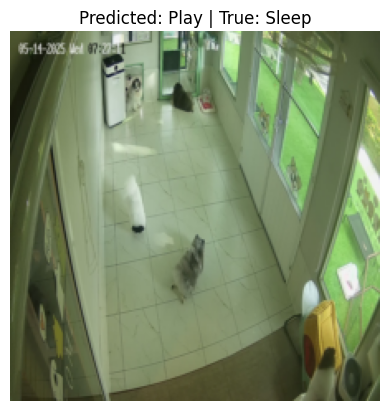

In [62]:
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

for idx, pred_label, true_label in misclassified[:5]:
    image_tensor, _ = val_subset[idx]
    image_tensor = unnormalize(image_tensor.cpu())  # unnormalize
    image_display = transforms.ToPILImage()(image_tensor)

    plt.imshow(image_display)
    plt.axis('off')
    plt.title(f"Predicted: {train_dataset.classes[pred_label]} | True: {train_dataset.classes[true_label]}")
    plt.show()


In [63]:

y_true, y_pred = evaluate(model, val_loader, criterion)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


 Val Loss :) 0.4122, Accuracy: 97.79%


ValueError: too many values to unpack (expected 2)

              precision    recall  f1-score   support

         Eat       1.00      1.00      1.00        39
        Play       0.94      1.00      0.97        33
       Sleep       1.00      0.97      0.98        64

    accuracy                           0.99       136
   macro avg       0.98      0.99      0.98       136
weighted avg       0.99      0.99      0.99       136

 Val Loss :) 0.3292, Accuracy: 97.79%

❌ Showing up to 5 misclassified validation images:



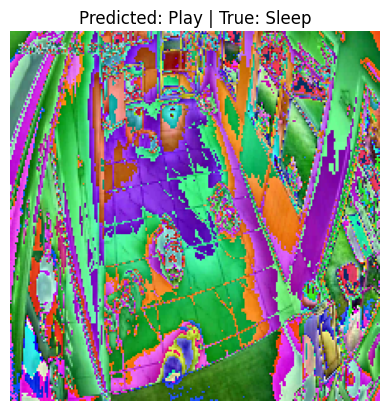

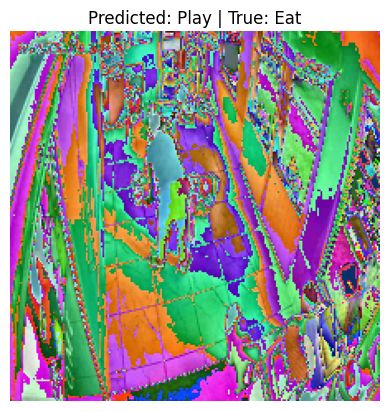

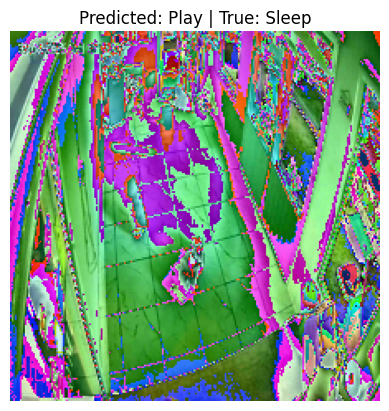

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Show misclassified examples
y_true, y_pred, misclassified = evaluate(model, val_loader, criterion)

print("\n❌ Showing up to 5 misclassified validation images:\n")

for idx, pred_label, true_label in misclassified[:5]:
    image_tensor, _ = val_subset[idx]
    image_display = transforms.ToPILImage()(image_tensor.cpu())

    plt.imshow(image_display)
    plt.axis('off')
    plt.title(f"Predicted: {train_dataset.classes[pred_label]} | True: {train_dataset.classes[true_label]}")
    plt.show()


In [ ]:
#Tester(see Image)

In [ ]:
from torchvision import transforms
from PIL import Image

# Load a test image
image = Image.open(r"D:\DOG project\EatFrames\PetRoom_FUck_u_FUck_u_20250514075829_20250514082619_250732_clip_084\frame_00001.jpg").convert("RGB")

# Use the actual transform object, not self
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trans = transform(image)


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# If image is a tensor (after transform), convert it back to PIL for display
image_display = F.to_pil_image(trans)

# Show the image
plt.imshow(image_display)
plt.axis('off')  # Hide axis ticks
plt.title("Transformed Image")
plt.show()
plt.imshow(image)
plt.axis('off')  # Hide axis ticks
plt.title("Original")
plt.show()



In [73]:
import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
import numpy as np
import os

# === CONFIG ===
video_path = r"C:\Users\Public\iVMS-4200 Site\UserData\Video\Mix\demo3.mp4"
model_weights = r"D:\DOG project\model.pth"  # ✅ full path to model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["Eat", "Play", "Sleep"]
frame_skip = 5  # process every 5th frame

# === CHECK FILES EXIST ===
if not os.path.exists(video_path):
    raise FileNotFoundError(f"❌ Video file not found: {video_path}")
if not os.path.exists(model_weights):
    raise FileNotFoundError(f"❌ Model weights not found: {model_weights}")

# === LOAD MODEL ===
model = models.resnet18(weights=None)  # ⛔ deprecated 'pretrained=False' is replaced
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_weights, map_location=device))
model = model.to(device)
model.eval()

# === TRANSFORMS ===
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === VIDEO SETUP ===
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"❌ Cannot open video: {video_path}")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_with_preds.mp4', fourcc, fps, (w, h))

frame_idx = 0
label = "..."  # default label before prediction

# === PROCESS VIDEO ===
while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % frame_skip == 0:
        try:
            # Frame to model input
            image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            input_tensor = val_transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(input_tensor)
                _, pred = torch.max(outputs, 1)
                label = class_names[pred.item()]
        except Exception as e:
            label = "Error"
            print(f"[!] Error on frame {frame_idx}: {e}")

    # === OVERLAY PREDICTION ===
    cv2.putText(frame, f"Prediction: {label}", (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

    # Show and write
    cv2.imshow("Activity Prediction", frame)
    out.write(frame)

    if cv2.waitKey(1) == ord('q'):
        break

    frame_idx += 1

# === CLEANUP ===
cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Video processed and saved as 'output_with_preds.mp4'")


✅ Video processed and saved as 'output_with_preds.mp4'


<Figure size 600x500 with 0 Axes>

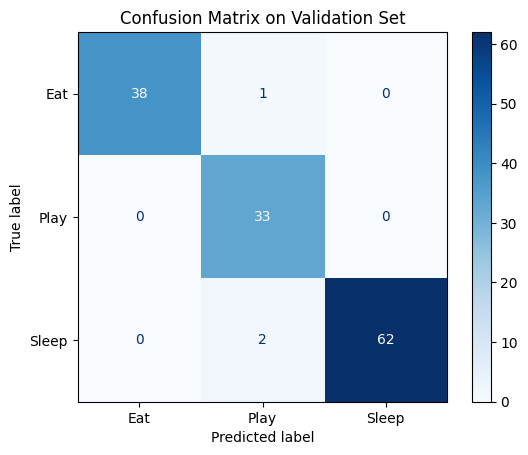

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true, y_pred must come from your final evaluate() call
# Make sure these are populated:
# y_true, y_pred = evaluate(model, val_loader, criterion)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

# Plot and save
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()
